##Построение функции, прогнозирующей погоду,
##с последующей её реализацией на микроконтроллере
##Arduino

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#ML
from sklearn.model_selection import train_test_split #разделение выборка на обучающую и тестовую
from sklearn.model_selection import GridSearchCV #подбор гиперпараметров методом сетки
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler  #для масштабирования данных
from sklearn.model_selection import GridSearchCV #подбор гиперпараметров методом сетки

from sklearn.linear_model import LinearRegression #лдинейная регрессия
from sklearn.neighbors import KNeighborsRegressor  #регрессия на основе метода ближайших соседей
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor 
from sklearn.svm import SVR

#metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

##Загрузка файла с замерами параметров атмосферы 

In [ ]:
#локального
#from google.colab import files
#fn=list(files.upload())[0]

#github
!git clone https://github.com/RUS02/BMSTU_2022
#fn = '/content/BMSTU_2022/27612.19.11.2021.19.11.2022.1.0.0.ru.utf8.00000000.csv.gz' # 1 год
fn  = '/content/BMSTU_2022/27612.01.07.2015.07.12.2022.1.0.0.ru.utf8.00000000.csv.gz' # 7 лет

!gunzip $fn
d=pd.read_csv(fn[:-3],sep=';',skiprows=6,index_col=False)
#Оставим только нужное и переименуем столбец с привязкой к метеостанции в имени
d=d[[d.columns[0],'T','Po','U','RRR']].rename(columns = {d.columns[0] : 'DT'})
# Столбцы:
# DT - ДатаВремя, замеры каждые 3ч.
# T  - Температура
# Po - Давление
# U  - Влажность
#RRR - Количество осадков


Cloning into 'BMSTU_2022'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [ ]:
d.head(5)

,DT,T,Po,U,RRR
0,07.12.2022 18:00,-8.6,755.2,69.0,Осадков нет
1,07.12.2022 15:00,-7.6,755.7,63.0,NaN
2,07.12.2022 12:00,-8.6,756.7,69.0,NaN
3,07.12.2022 09:00,-9.6,757.2,70.0,Осадков нет
4,07.12.2022 06:00,-8.2,757.3,57.0,Осадков нет


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21881 entries, 0 to 21880
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DT      21881 non-null  object 
 1   T       21879 non-null  float64
 2   Po      21880 non-null  float64
 3   U       21878 non-null  float64
 4   RRR     10827 non-null  object 
dtypes: float64(3), object(2)
memory usage: 854.9+ KB


##Заполнение пропусков и перекодировки

In [ ]:
print('========T=======')
print(*list(d[d['T'].isna()].index))
print('========Po======')
print(*list(d[d.Po.isna()].index))
print('========U=======')
print(*list(d[d.U.isna()].index))

========T=======
1869 7029
========Po======
3842
========U=======
1869 7029 15189


In [ ]:
#Пропуски по температуре, давлению и влажности заполним средним между "До" и "После"
for t_idx in d[d['T'].isna()].index:
  d.loc[t_idx,'T']=(d.loc[t_idx-1]['T']+d.loc[t_idx+1]['T'])/2

for p_idx in d[d.Po.isna()].index:
  d.loc[p_idx,'Po']=(d.loc[p_idx-1]['Po']+d.loc[p_idx+1]['Po'])/2

for u_idx in d[d.U.isna()].index:
  d.loc[u_idx,'U']=(d.loc[u_idx-1]['U']+d.loc[u_idx+1]['U'])/2

In [ ]:
#Нет осадков - 0
d.RRR=d.RRR.fillna('0.0')

In [ ]:
d[d.RRR.str.replace(' ','').str.isalpha()].RRR.value_counts()

Осадков нет      5825
Следы осадков     789
Name: RRR, dtype: int64

In [ ]:
#Осадков исчезающе мало - 0
d.loc[d.RRR.str.replace(' ','').str.isalpha(),'RRR']='0.0'

In [ ]:
#Разобъем дату на 4 сезона
d[['m','m0','m1','m2','m3']]=0
d.m=d.DT.str[3:5].map({'01':0,'02':0,'03':1,'04':1,'05':1,'06':2,'07':2,'08':2,'09':3,'10':3,'11':3,'12':0})
d.loc[d.m==0,'m0']=1
d.loc[d.m==1,'m1']=1
d.loc[d.m==2,'m2']=1
d.loc[d.m==3,'m3']=1
#и час суток
d['hh']=d.DT.str[11:13]
#Лишнее удаляем
d.drop(['m','DT'],axis=1,inplace=True)
d.hh=d.hh.astype(int)
d.RRR=d.RRR.astype(float)

In [ ]:
d.head(10)

,T,Po,U,RRR,m0,m1,m2,m3,hh
0,-8.6,755.2,69.0,0.0,1,0,0,0,18
1,-7.6,755.7,63.0,0.0,1,0,0,0,15
2,-8.6,756.7,69.0,0.0,1,0,0,0,12
3,-9.6,757.2,70.0,0.0,1,0,0,0,9
4,-8.2,757.3,57.0,0.0,1,0,0,0,6
5,-7.2,757.6,55.0,0.0,1,0,0,0,3
6,-6.2,757.6,56.0,0.0,1,0,0,0,0
7,-4.9,757.9,52.0,0.0,1,0,0,0,21
8,-4.4,758.4,54.0,0.0,1,0,0,0,18
9,-5.2,758.8,50.0,0.0,1,0,0,0,15


##Синтезируем из столбца строку, содержащую исторические и прогнозируемое значения

In [ ]:
def col2row(df, cols_single,cols_history,len_history,cols_future,len_future):
  '''
  Из DataFrame с историческими данными в столбце
  - df - DataFrame
  - cols_single  - данные характеризуют настоящий момент
  - cols_history - исторические данные
  - len_history  - кол-во замеров исторических значений, в т.ч. в настоящий момент
  - cols_future  - прогнозируемые данные
  - len_future   - дальность прогнозируемых значений
  - exclude_history - столбцы не присутствующие в истории
  - exclude_future  - столбцы не присутствующие в прогнозе
  Формирует: 
  - новый DataFrame, с историческими данными и прогнозируемым значением в строке
  - список столбцов истории
  - список столбцов прогнозируемых
  '''
  if len(cols_single)==0:return()
  df['idx'] = df.index - len_history - len_future+1  
  df_rez=df.loc[len_future:df.shape[0]-len_history,cols_single+['idx']].set_index('idx')

  x_col=[]
  for i in range(len_history):
    x_c=[x+str(i+1-len_history) for x in cols_history]
    x_col+=x_c
    df_rez[x_c]=df.loc[len_future+len_history-1-i:df.shape[0]-1-i,cols_history+['idx']].set_index('idx')
    df['idx'] +=1
  y_col=[x+'+'+str(len_future) for x in cols_future]
  df_rez[y_col]=df.loc[0:df.shape[0]-len_future-len_history,cols_future]
  df.drop('idx',axis=1,inplace=True)
  return(df_rez.loc[0:],cols_single+x_col,y_col)

In [ ]:
#Конструирование данных для прогноза на 3, 6, 9, 12 часов
#Исключаем столбец осадков в исходных данных т.к. нет датчика осадков,
#но оставляем "Кол-во осадков" в прогнозе
#Пример вызова
ser_1,X_col_1,y_col_1=col2row(d,['m0','m1','m2','m3','hh'],['T','Po','U'],4,['T','Po','U','RRR'],1)
print(X_col_1)
print(y_col_1)
ser_1.head()

['m0', 'm1', 'm2', 'm3', 'hh', 'T-3', 'Po-3', 'U-3', 'T-2', 'Po-2', 'U-2', 'T-1', 'Po-1', 'U-1', 'T0', 'Po0', 'U0']
['T+1', 'Po+1', 'U+1', 'RRR+1']


,m0,m1,m2,m3,hh,T-3,Po-3,U-3,T-2,Po-2,...,T-1,Po-1,U-1,T0,Po0,U0,T+1,Po+1,U+1,RRR+1
idx,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,6,-8.2,757.3,57.0,-9.6,757.2,...,-8.6,756.7,69.0,-7.6,755.7,63.0,-8.6,755.2,69.0,0.0
1,1,0,0,0,3,-7.2,757.6,55.0,-8.2,757.3,...,-9.6,757.2,70.0,-8.6,756.7,69.0,-7.6,755.7,63.0,0.0
2,1,0,0,0,0,-6.2,757.6,56.0,-7.2,757.6,...,-8.2,757.3,57.0,-9.6,757.2,70.0,-8.6,756.7,69.0,0.0
3,1,0,0,0,21,-4.9,757.9,52.0,-6.2,757.6,...,-7.2,757.6,55.0,-8.2,757.3,57.0,-9.6,757.2,70.0,0.0
4,1,0,0,0,18,-4.4,758.4,54.0,-4.9,757.9,...,-6.2,757.6,56.0,-7.2,757.6,55.0,-8.2,757.3,57.0,0.0


#Оптимизации гиперпараметров синтезирования данных:
- Количество исторических замеров
- Степень полинома предобработки параметров
##Для указанных:
- Дальности прогноза (в кол-ве интервалов замеров)
- Алгоритма ML


##Функция оптимизации


In [ ]:
def GridSearchPreproc(d,len_future=[1],len_history=[1],degree=[1],ML_engine={'Linear':LinearRegression()}):
  scl=MinMaxScaler()

  print('Дальность| Кол-во| Степень |                                                             |       |                                                             |')
  print(' прогноза|замеров| полинома|                             MSE                             | сред. |                             MAE                             | сред. ')
  print(' шт | ч. |истории|признаков|                                                             |       |                                                             |')

  #обучаем на сетке гиперПараметров
  for ilen_future in len_future:
    print('='*167)
    for iML_engine in ML_engine:
      ML_eng=ML_engine[iML_engine]
      mae_min=1
      mse_min=1
      for ilen_history in len_history:
        
        for idegree in degree:
          ser,X_col,y_col=col2row(d,['m0','m1','m2','m3','hh'],['T','Po','U'],ilen_history,['T','Po','U','RRR'],ilen_future)
          
          if 1==idegree:
            X=scl.fit_transform(ser[X_col])
          else:
            X=PolynomialFeatures(idegree).fit_transform(scl.fit_transform(ser[X_col]))
          ser[y_col]=scl.fit_transform(ser[y_col])

          X_train, X_test, y_train, y_test = train_test_split(X, ser[y_col], test_size=0.3, random_state=42,)

          mse={}
          mae={}
          mse_s=0
          mae_s=0
          for c in y_col:
            ML_eng.fit(X_train, y_train[c])
            y_pred=ML_eng.predict(X_test)
            mse_r=mean_squared_error(y_test[c], y_pred)
            mae_r=mean_absolute_error(y_test[c], y_pred)
            mse[c]=mse_r
            mae[c]=mae_r
            mse_s+=mse_r
            mae_s+=mae_r
          if mse_min>mse_s/len(mse):
            mse_min=mse_s/len(mse)
            mse_par=[ilen_future,ilen_history,idegree]
          if mae_min>mae_s/len(mae):
            mae_min=mae_s/len(mae)
            mae_par=[ilen_future,ilen_history,idegree]
          print(f'  {ilen_future} |  {ilen_future*3} |   {ilen_history}   |     {idegree}   |{printDict(mse)}|{"{:7.5f}".format(mse_s/len(mse))}|{printDict(mse)}|{"{:7.5f}".format(mae_s/len(mae))}')
      print(iML_engine,'mse_min =',mse_min,mse_par,'mae_min =',mae_min,mae_par)
      if 'Linear'!=iML_engine:print(f'Лучшие параметры : {ML_eng.best_params_}')

def printDict(d):
  s=''
  for k in d:
    s+=k+' : '+str("{:7.5f}".format(d[k]))+', '
  return(s[:-2])

##Оптимизации гиперпараметров

In [ ]:
GridSearchPreproc(d,
                  len_history=[1,2,3,4],
                  len_future =[1,2,3,4],
                  degree     =[1,2,3],
                  ML_engine={'Linear': LinearRegression(),
                             'KNN'   : GridSearchCV(KNeighborsRegressor(),
                                                    param_grid = {'n_neighbors':[3,5]},
                                                    cv = 5)
                            } 
                  )

Дальность| Кол-во| Степень |                                                             |       |                                                             |
 прогноза|замеров| полинома|                             MSE                             | сред. |                             MAE                             | сред. 
 шт | ч. |истории|признаков|                                                             |       |                                                             |
  1 |  3 |   1   |     1   |T+1 : 0.00106, Po+1 : 0.00022, U+1 : 0.01442, RRR+1 : 0.00094|0.00416|T+1 : 0.00106, Po+1 : 0.00022, U+1 : 0.01442, RRR+1 : 0.00094|0.03400
  1 |  3 |   1   |     2   |T+1 : 0.00074, Po+1 : 0.00022, U+1 : 0.01109, RRR+1 : 0.00090|0.00324|T+1 : 0.00074, Po+1 : 0.00022, U+1 : 0.01109, RRR+1 : 0.00090|0.03040
  1 |  3 |   1   |     3   |T+1 : 0.00061, Po+1 : 0.00022, U+1 : 0.00986, RRR+1 : 0.00087|0.00289|T+1 : 0.00061, Po+1 : 0.00022, U+1 : 0.00986, RRR+1 : 0.00087|0.02807
  1 | 

#Вывод 1.
#Используемые гиперпараметры синтезирования данных
### Для унификации решения в качестве гиперпараметров синтеза данных 
### будем использовать наиболее успешные по MSE
### len_history = 2, degree = 3
### для всех len_future = [1, 2, 3, 4],

In [ ]:
# Средняя погрешность от наилучшего решения линейной регрессии при унификации
# len_history = 2, degree = 3
# будет незначительна:

err_mse=((0.00255-0.00232) +(0.0042-0.0042)+(0.00518-0.00518)+(0.0058-0.0058))/4
err_mae=((0.02556-0.02429)+(0.03502-0.03436)+(0.0407-0.04043)+(0.04410-0.04399))/4

print(f'Средняя погрешность от наилучшего err_mse = {round(err_mse,7)} err_mae = {round(err_mae,7)}')
#Средняя погрешность от наилучшего err_mse = 0.00019 err_mae = 0.001355


Средняя погрешность от наилучшего err_mse = 5.75e-05 err_mae = 0.0005775


#Прогноз нейронной сетью

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 40)                3160      
                                                                 
 dense_38 (Dense)            (None, 10)                410       
                                                                 
 dense_39 (Dense)            (None, 4)                 44        
                                                                 
Total params: 3,614
Trainable params: 3,614
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
31/31 [==============================] - 1s 11ms/step - loss: 0.3986 - mse: 0.2297 - mae: 0.3986 - val_loss: 0.2617 - val_mse: 0.1106 - val_mae: 0.2617
Epoch 2/2000
31/31 [==============================] - 0s 5ms/step - loss: 0.2055 - mse: 0.0727 - mae: 0.2055 - val_loss: 0.1392 - val_mse: 0.0342 - va

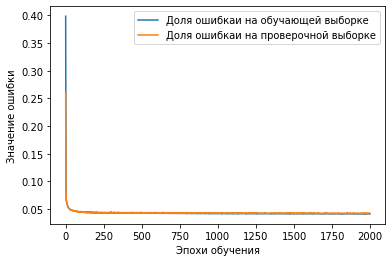

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv1D
from tensorflow.keras.models import Sequential

ser,X_col,y_col=col2row(d,['m0','m1','m2','m3','hh'],['T','Po','U'],2,['T','Po','U','RRR'],4)
X=PolynomialFeatures(2).fit_transform(MinMaxScaler().fit_transform(ser[X_col]))
ser[y_col]=MinMaxScaler().fit_transform(ser[y_col])

X_train, X_test, y_train, y_test = train_test_split(X, ser[y_col], test_size=0.3, random_state=42,)

model = Sequential()
model.add(Dense(40, input_shape = (X_train.shape[1], ) , activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(4, activation = 'linear'))
model.summary()

#компилируем модель
model.compile(loss = 'mae',
              optimizer = 'adam',
              metrics =  ['mse','mae'])

history = model.fit(X_train, y_train,
          batch_size = 500,
          epochs = 2000,
          validation_data = (X_test, y_test),
          verbose = 1)

#визуализация обучения нейронки
plt.plot(history.history['loss'],
         label = 'Доля ошибкаи на обучающей выборке')
plt.plot(history.history['val_loss'],
         label = 'Доля ошибкаи на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

##Результаты прогноза нейросетью 
###1. Обнаружено ухудшение прогноза при добавлении полиномиальных параметров
###2. По MSE MAE сравним другими регрессиями, и не улучшается при увеличении эпох
### val_mse: 0.0058, val_mae: 0.0422 против 0.00580, 0.04410 линейной регрессии
###3. В итоге обучения незначительное переобучение


#Вывод 2.
###Линейная регрессия с полиномиальными признаками
###позволяет делать достаточно точный прогноз погоды до 12 часов.
###Учитывая также низкую сложность вычислений,
###выбираем её для реализации на микроконтроллере
##Arduino


#Извлекаем параметры, восстанавливаем алгоритм преобразования и прогноза
#и имплементируем их в функцию прогноза погоды на 12 часов



In [ ]:
#отлаживаем на примере прогноза на 4 замера в будущее (12 часов)
#Прогноз методами sklearn
ser,X_col,y_col=col2row(d,['m0','m1','m2','m3','hh'],['T','Po','U'],2,['T','Po','U','RRR'],4)
ser2=ser.copy()

X_scale=MinMaxScaler()
y_scale=MinMaxScaler()
X_scale.fit(ser[X_col])
ser[X_col]=X_scale.transform(ser[X_col])
y_scale.fit(ser[y_col])
ser[y_col]=y_scale.transform(ser[y_col])

X_train, X_test, y_train, y_test = train_test_split(PolynomialFeatures(3).fit_transform(ser[X_col]), ser[y_col], test_size=0.3, random_state=42,)
lr=LinearRegression().fit(X_train, y_train[y_col])

#Прогноз методами sklearn
y_scale.inverse_transform(lr.predict(PolynomialFeatures(3).fit_transform(X_scale.transform(ser2[X_col]))))[0]

array([-8.27370911e+00,  7.56292236e+02,  6.69436035e+01,  2.18448639e-01])

In [ ]:
def LA_predict(x):
  
  #MinMaxScaler.transform()
  #l0=(np.array(x)-X_scale.data_min_)/(X_scale.data_max_-X_scale.data_min_)
  l0=[1]+list((np.array(x)-np.array([0,0,0,0,0,-29.9,712.8,12,-29.9,712.8,12],dtype=float))/np.array([1,1,1,1,23,64.3,59.8,88.0,64.3,59.8, 88],dtype=float))

  #PolynomialFeatures.transform(3)
  l=[]
  l1=[1,2,3,5,7,11,13,17,19,23,29,31]
  l2=[1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 4, 6, 10, 14, 22, 26, 34, 38, 46, 58, 62, 9, 15, 21, 33, 39, 51, 57, 69, 87, 93, 25, 35, 55, 65, 85, 95, 115, 145, 155, 49, 77, 91, 119, 133, 161, 203, 217, 121, 143, 187, 209, 253, 319, 341, 169, 221, 247, 299, 377, 403, 289, 323, 391, 493, 527, 361, 437, 551, 589, 529, 667, 713, 841, 899, 961, 8, 12, 20, 28, 44, 52, 68, 76, 92, 116, 124, 18, 30, 42, 66, 78, 102, 114, 138, 174, 186, 50, 70, 110, 130, 170, 190, 230, 290, 310, 98, 154, 182, 238, 266, 322, 406, 434, 242, 286, 374, 418, 506, 638, 682, 338, 442, 494, 598, 754, 806, 578, 646, 782, 986, 1054, 722, 874, 1102, 1178, 1058, 1334, 1426, 1682, 1798, 1922, 27, 45, 63, 99, 117, 153, 171, 207, 261, 279, 75, 105, 165, 195, 255, 285, 345, 435, 465, 147, 231, 273, 357, 399, 483, 609, 651, 363, 429, 561, 627, 759, 957, 1023, 507, 663, 741, 897, 1131, 1209, 867, 969, 1173, 1479, 1581, 1083, 1311, 1653, 1767, 1587, 2001, 2139, 2523, 2697, 2883, 125, 175, 275, 325, 425, 475, 575, 725, 775, 245, 385, 455, 595, 665, 805, 1015, 1085, 605, 715, 935, 1045, 1265, 1595, 1705, 845, 1105, 1235, 1495, 1885, 2015, 1445, 1615, 1955, 2465, 2635, 1805, 2185, 2755, 2945, 2645, 3335, 3565, 4205, 4495, 4805, 343, 539, 637, 833, 931, 1127, 1421, 1519, 847, 1001, 1309, 1463, 1771, 2233, 2387, 1183, 1547, 1729, 2093, 2639, 2821, 2023, 2261, 2737, 3451, 3689, 2527, 3059, 3857, 4123, 3703, 4669, 4991, 5887, 6293, 6727, 1331, 1573, 2057, 2299, 2783, 3509, 3751, 1859, 2431, 2717, 3289, 4147, 4433, 3179, 3553, 4301, 5423, 5797, 3971, 4807, 6061, 6479, 5819, 7337, 7843, 9251, 9889, 10571, 2197, 2873, 3211, 3887, 4901, 5239, 3757, 4199, 5083, 6409, 6851, 4693, 5681, 7163, 7657, 6877, 8671, 9269, 10933, 11687, 12493, 4913, 5491, 6647, 8381, 8959, 6137, 7429, 9367, 10013, 8993, 11339, 12121, 14297, 15283, 16337, 6859, 8303, 10469, 11191, 10051, 12673, 13547, 15979, 17081, 18259, 12167, 15341, 16399, 19343, 20677, 22103, 24389, 26071, 27869, 29791]
  #some magic...
  for z in l2:
    z_=z
    z2=1
    for i in range(3):
      for j in range(11,-1,-1):
        if z_%(l1[j])==0:
          z2*=l0[j]
          z_//=(l1[j])
          break
    l.append(z2)
  
  #LinearRegression.transform
  lr_coef_=np.array([
  [310153.18465445255, 14406781878.548191, 39875851496.57542, 16844173139.59988, 47485059386.190346, -34820367291.082085, 24009127135.955875, -124575792665.05322, 50865477849.4442, -17445060142.997375, -56260313703.935585, -3826571681.977248, 61208619293.22471, -4404756662.938176, -6267294028.001819, 4712349773.902582, 34597202667.22394, -5147295352.830749, 66464333948.26221, -32179416058.194523, 11415678422.713207, 29338225374.46833, 20953347573.12909, 90276169385.65155, 5985795022.260223, 613936149.142204, 19909026825.414505, 14043400679.865355, 72500726038.68355, 8095447481.277648, 21776460529.065193, 58182017418.695465, 2031146407.8063166, 47643689556.339455, -699726490.1837345, 16703589275.499931, -13329536600.447987, 62014261413.25189, -24714521375.979286, 8723247301.512735, 28689107907.331024, 2209124983.9762363, 31378726995.154854, 17248423804.18357, -12077521523.39707, 61017837422.25206, -25910856676.54076, 8795333057.341473, 28092666961.94436, 2008736976.8433182, 11359736421.32014, -109985631.35906982, -17350869787.74096, 2199749358.7998314, -7655192302.180902, 870100252.4694138, 6667085624.292137, -2066245341.9301324, -1339615723.5637512, -7117926517.662959, -6829878976.16622, 2554990778.39979, 5192898067.841763, -20578450593.87355, -20233863991.826843, -18278018351.68456, -3809258011.691847, -23297637371.6651, -18234934848.148014, 26000533316.17591, -1434065778.2920265, 29071730604.168137, -14631900825.87087, -11745659910.647114, 15896034303.889387, 9438502842.295496, -23415657667.672935, 9721711432.150084, 35620630521.88752, -16792832.12899564, -14521898.552063001, 89005439.66177443, 223164624.07164574, -18861831778.078705, 58111458722.60162, -18686061789.86005, 6029381717.968964, 26922088324.63052, -17126775891.185524, -121571107.97339822, 96319584.51974626, -79330759.15357727, 100878446.74373858, 2474.5566553256076, 73622392.48487158, -114744028.64489442, 7272465.669784909, 98487446.16914572, 7770852.454887024, -63650807.69361796, 17851825.346741516, 65971133.63274061, 6626186.9368501995, 6060479.933749419, -3097240.581228107, -61237228.531436086, 52928465.269305736, -100451247.62620832, 33965894.78287181, 68819035.32311246, -59272756.42520247, -66565075.69426786, 25071449.94391266, -13574246.35092219, 21006679.268695787, 31128414.032594036, -11359736422.03056, 109985630.36596012, 17350869790.047176, -2199749358.901059, 7655192302.600724, -870100255.0860271, -6667085623.915722, 2066245338.218048, 1339615710.8191128, 7117926515.365882, 6829878974.271544, -2554990771.190796, -5192898067.607533, 20578450603.903496, 20233863991.73054, 18278018354.25033, 3809257985.073696, 23297637369.07078, 18234934848.451538, -26000533317.035282, 1434065777.1764984, -29071730605.48075, 14631900831.09135, 11745659912.92246, -15896034303.484575, -9438502825.979916, 23415657670.328884, -9721711431.534569, -18915989188.130608, -2775706.418216589, -18059640.8975729, 14911340465.74493, -38052527812.591, 52075066631.03592, -58960925329.42034, -4331400387.564269, -1921703718.7815037, 1795425273.9201097, 562197.7476878372, -7303347.971506937, 2112666.161806775, 7154274.639296625, -144122.86261727213, -5548701.8301422885, -16356067.46296382, -5521330.330495664, -383214.1314580436, -1051257.3649068463, -2529101.6133564855, -2288018.2586046904, 906190.4389463908, -8062818.975733468, 2118699.808150031, -5640557.030539562, -4798928.646909987, -11359736421.835407, 109985630.11973381, 17350869790.527603, -2199749359.05192, 7655192302.764496, -870100255.733532, -6667085623.739643, 2066245339.8939657, 1339615715.1433315, 7117926515.867252, 6829878972.06927, -2554990774.1453857, -5192898066.82374, 20578450603.208344, 20233863992.10146, 18278018350.51502, 3809257986.994737, 23297637368.946598, 18234934848.445923, -26000533317.04367, 1434065776.6076279, -29071730605.41555, 14631900831.828934, 11745659915.833282, -15896034303.99962, -9438502826.977781, 23415657670.68172, -9721711431.6236, 46748168998.09386, 247892.64877918822, 18116778015.67956, -10679590530.996832, 62561531254.65795, -26150956471.84295, 8721812838.711937, 27571205794.55992, 1617446697.5757332, -171327.98539883943, -859982.2938776992, 781214.5476296704, -1761484.8187800155, -14973.817370697108, -1714535.1642010005, -676740.3912971865, -208105.01164741165, -11359736421.952066, 109985630.956501, 17350869791.59825, -2199749359.070254, 7655192302.081722, -870100256.7673874, -6667085623.779377, 2066245341.5036726, 1339615721.437481, 7117926517.537041, 6829878967.897756, -2554990781.7953625, -5192898068.7305, 20578450603.728508, 20233863995.57163, 18278018345.631104, 3809257985.890213, 23297637365.79544, 18234934848.730797, -26000533318.910633, 1434065772.9009972, -29071730606.065254, 14631900834.784758, 11745659921.116394, -15896034302.139238, -9438502825.971754, 23415657674.023075, -9721711431.182379, 32372245313.211494, 17571943487.327644, -11931605612.780209, 63557955247.27497, -24954621171.927074, 8649727086.933582, 28167646737.758743, 1817834704.6080844, -11359736422.05108, 109985629.58361053, 17350869789.879715, -2199749359.123398, 7655192303.1931, -870100254.9790535, -6667085623.792259, 2066245343.3621254, 1339615717.7614303, 7117926517.30213, 6829878967.548792, -2554990775.899786, -5192898066.082842, 20578450604.992485, 20233863993.23069, 18278018348.577568, 3809257984.0171003, 23297637367.82537, 18234934848.6009, -26000533318.433773, 1434065775.7545881, -29071730605.478573, 14631900833.076231, 11745659917.10913, -15896034304.276264, -9438502825.776821, 23415657671.700264, -9721711431.525791, 0.5196723937988281, 1.4326419830322266, -1.854299545288086, -0.19913864135742188, -0.654052734375, 2.302276611328125, -0.3343982696533203, -15.748347282409668, -16.77116584777832, -1.8696155548095703, 35.121872901916504, 18.517820358276367, -1.1560287475585938, -0.11687469482421875, -2.558598518371582, 16.00389289855957, 1.3759613037109375, 1.6392402648925781, 0.2651824951171875, 2.9037609100341797, 2.3406600952148438, -0.43433570861816406, -19.534883499145508, -17.88079261779785, 0.3131523132324219, -1.3134384155273438, -1.4647178649902344, 0.3139839172363281, 12.625694632530212, 70.70686054229736, -0.4628868103027344, -41.090096950531006, -60.02885341644287, 5.0372772216796875, 40.51594936847687, 10.025636672973633, -145.04125308990479, -72.70387673377991, 5.89085578918457, 0.3446617126464844, 0.6311359405517578, -6.7522430419921875, -0.4611186981201172, 46.8103141784668, 128.0157642364502, -7.537624359130859, 32.755154609680176, -6.845625877380371, 0.007294654846191406, 2.2786388397216797, 13.44113540649414, -50.962472438812256, -14.457223892211914, -14.875238418579102, -2.937084197998047, -12.413219451904297, -23.70861053466797, 4.999351501464844, 76.92289352416992, 100.73981630802155, -0.7965097427368164, 22.807029724121094, 28.848295211791992, -1.8726997375488281, 0.10268402099609375, -0.13414382934570312, 2.502939224243164, -1.0710639953613281, 0.38614845275878906, 10.63140869140625, 1.4947624206542969, 10.8843994140625, -4.216028213500977, 1.64739990234375, -18.78614044189453, -69.7356309890747, 2.490612030029297, -51.3594651222229, 1.481755256652832, -0.8988895416259766, -10.544441223144531, -14.130442142486572, 1.5929622650146484, -0.6310539245605469],
  [-83831.03203166374, -14289558501.78192, -21396608748.449184, 18999124500.186428, 25514956813.241375, -2179664548.727059, 7013123957.217806, -13806173590.414215, 11814262761.301186, 10116498054.543692, 10221105589.869379, 4077526666.07637, -15686305720.756172, -158643646.106087, -1240179839.6823325, -178035585.98502806, -9142373532.212168, -8305152879.592024, -7015288827.990569, -15769425954.198376, -8630831232.086216, -8046371197.079639, -17166572640.982447, -33743815173.316044, 890293737.8480456, 275935134.99363387, -4482179865.114854, -22355125638.011375, -1525735433.6542199, -22157368667.70611, -8000551004.161972, -7310556500.116882, -2292115505.9060483, -27195109570.380257, 667265788.811434, 535369772.22600555, -3911528932.060936, 6857013534.895939, -6033314204.5650215, -4974275936.192475, -4971805991.028263, -1840353864.6423006, -30778503802.36122, 948967489.6118765, -3429808462.0255322, 6616775392.682965, -5899394026.201704, -5015694146.721941, -5283918657.723761, -1959214000.5668135, 95567805.5559578, -660172981.0011015, -757068995.1568823, 2279368865.961851, -198461177.81315708, 1024783946.6484108, -3775806611.2499456, -593754337.7813869, 3780589162.6605415, 466458432.5394211, -205707521.78541613, -960386406.3322449, 1455423648.059907, -1981317586.2524576, 439378283.85327923, -1884376890.5024629, -1804275184.8998537, -2564735241.513689, 345313569.78566456, 6997974638.701988, 600651076.1783196, 2895043113.0377502, -5465212734.469562, 1593648141.3048215, 4837600432.352998, 2112124442.053906, -4244814667.8830757, 7686630539.128384, -5557453908.924263, 5762730.989806898, -12867336.41690002, 19185293.568738047, 11322038080.877586, 1292028922.1372442, 20821462415.438576, 3955163192.5109725, -1485666823.4405494, -2174734389.0869474, 13089045974.53785, -1970155.2501335575, 7894393.900553873, -2346523.7624980332, 18840396.448143408, 30733980.623785, 24767581.858952966, -38837161.76747306, -5823047.421526702, 20898083.109112065, 3225081.069316649, -20834254.933454208, 4932089.0273621, 10689848.208522163, 8665099.444235528, 3505477.267139434, -1953550.6194793608, -19854864.28155641, 5586001.385909505, -13007918.821735539, 5696181.378920592, 2125967.009695089, -12589538.989084259, -12785374.141357467, 4430618.456467025, -4172111.9134148774, 757379.2288444209, 4936843.413928718, -95567805.6030221, 660172979.6677644, 757068995.5282736, -2279368865.9735346, 198461179.0061273, -1024783946.8699641, 3775806611.3703036, 593754334.580605, -3780589185.824514, -466458426.20939684, 205707531.5141387, 960386429.704463, -1455423656.4305847, 1981317539.4327183, -439378285.7683525, 1884376911.952159, 1804275279.4157586, 2564735241.6796293, -345313568.5793371, -6997974644.06997, -600651073.764091, -2895043115.6275396, 5465212729.541984, -1593648162.3678532, -4837600423.949665, -2112124489.9452395, 4244814667.3229804, -7686630537.257507, 19607105790.297436, 652621.8459085725, -1088558.812145281, 6661844413.814834, 15342001680.594141, 15331909023.035223, 10343105906.066183, -2115947051.6535926, -2910549088.04868, -1785411160.3812933, 908395.8565286135, 696416.7452137704, -1943832.556848437, 3660984.2549085957, -250834.50181986066, -3635593.9926866707, -2194451.681831652, -1042784.808694977, -922596.5441659696, -2824443.699845003, -963020.820123654, -556221.6170632967, -1203491.7798159095, -97084.14040457536, -468876.4054739868, -2201765.9075568104, -756443.2219857933, -95567805.60454464, 660172979.6573734, 757068995.0676326, -2279368866.035672, 198461179.0258689, -1024783946.3544868, 3775806611.3516192, 593754338.97894, -3780589189.303705, -466458426.4898901, 205707522.24747658, 960386433.81533, -1455423655.994915, 1981317535.7863348, -439378286.5641928, 1884376915.5591898, 1804275284.6945992, 2564735241.5876913, -345313568.7601719, -6997974643.948718, -600651072.8603783, -2895043115.232733, 5465212734.478188, -1593648166.3612962, -4837600424.167564, -2112124491.6341996, 4244814667.2374496, -7686630537.559083, -27337333060.89765, 145126.5130414135, 1644294776.4373589, -3101595026.1022606, 6949160054.976652, -5780948557.432127, -5142222119.483045, -5249299598.001878, -2237172801.4864893, 68008.11154109154, 129543.82440399265, -79243.47228740422, -130462.31990215619, 18844.435162128022, -85335.2271479441, -45867.53808701552, -74578.45125731442, -95567805.5748272, 660172979.6222448, 757068994.6054773, -2279368865.9922256, 198461179.0733862, -1024783945.905201, 3775806611.319523, 593754339.787806, -3780589196.8644114, -466458425.55000174, 205707520.71543288, 960386442.4108174, -1455423656.9952471, 1981317533.9051352, -439378290.447283, 1884376922.87307, 1804275288.618508, 2564735244.7243314, -345313568.58559203, -6997974644.652106, -600651068.7386489, -2895043115.5905504, 5465212735.135075, -1593648173.6954184, -4837600423.223236, -2112124493.9706674, 4244814663.925761, -7686630537.355209, -30269771142.312836, 1230697058.9746456, -3583315495.028948, 7189398196.885581, -5914868735.375022, -5100803909.359945, -4937186930.671487, -2118312665.8379154, -95567805.55356216, 660172979.7944508, 757068995.2261629, -2279368866.0044403, 198461178.8810892, -1024783946.5045595, 3775806611.390355, 593754337.7410693, -3780589193.805976, -466458426.15825653, 205707524.7007048, 960386438.1778198, -1455423657.0495744, 1981317536.5731165, -439378287.50538373, 1884376918.7689407, 1804275285.270369, 2564735241.270912, -345313568.6592064, -6997974644.364681, -600651071.8503406, -2895043115.5990343, 5465212733.257784, -1593648169.4778984, -4837600423.112404, -2112124493.0412302, 4244814667.688513, -7686630537.3419895, 0.01187896728515625, -0.09903907775878906, -0.4371042251586914, 0.09441280364990234, 0.07680511474609375, 0.3623771667480469, 0.0003094673156738281, 13.423380851745605, 16.226706504821777, 1.5063695907592773, -27.4767484664917, -16.495367348194122, 0.2664365768432617, -0.6497097015380859, 2.697197437286377, -15.866208910942078, -1.0786857604980469, -1.3110942840576172, -0.1460585594177246, -1.64085054397583, -2.59198921918869, 0.20273828506469727, 14.162065505981445, 16.284252882003784, -0.15706825256347656, 1.726424217224121, 1.0563631057739258, -0.0941476821899414, -39.2404260635376, -1.7393503189086914, -13.98571491241455, 114.6068663597107, -8.58545970916748, 13.935001373291016, 34.68536949157715, 13.66160136461258, 43.091819763183594, -76.99805641174316, -12.814053773880005, -1.293966293334961, 22.509456634521484, -20.98541557788849, 3.5985918045043945, -111.00425601005554, -26.30330181121826, -23.253265380859375, 43.19734764099121, 20.953706681728363, -1.2455387115478516, 81.83840799331665, 26.152355670928955, -0.20049047470092773, -239.5966091156006, 11.846076250076294, 3.2151241302490234, -2.8115365505218506, -58.65841054916382, -7.662997245788574, -37.884363651275635, 6.353638648986816, 4.76358699798584, 235.49109649658203, -19.17842936515808, 6.077505707740784, -0.059916019439697266, 0.5282058715820312, -4.186842918395996, 0.2675306797027588, -8.659891128540039, 9.209179878234863, -2.0853023529052734, 32.224546909332275, 9.820656418800354, -0.2385706901550293, 35.27322369068861, 30.154740810394287, 9.052148818969727, -6.563858985900879, -12.149291038513184, 0.07166004180908203, -77.62761783599854, 7.729156732559204, -7.421376347541809, 0.04800128936767578],
  [1469958.963476662, -99256251884.21669, -48937468520.87967, -18884226165.395695, -103126666223.23892, 79774350541.94412, -75112791749.4999, 328757041874.4824, -151574899135.60532, 28907342235.843884, 166541236450.39847, 14277762928.766054, 5244398929.8920355, 11559530038.508757, 16017222176.878176, -7819312439.731904, -21192320964.266182, 28257522353.11089, -219273888377.00668, 17242244134.481464, -34204847109.59564, -97202652486.1876, -4853188353.260368, -170741996191.1374, -15037506085.839087, -3119735557.2548356, -44974361273.35264, -4617615017.584824, -173438074845.98422, 21976342210.22268, -36506912071.62499, -161445686047.90384, -7931828196.863162, -78395453404.5566, 1455489882.451827, -37839007492.31323, 41087307287.3663, -163824340806.21387, 73817435368.54158, -14463536724.709717, -84760281888.61456, -7789002428.295193, -33506298136.32532, -40061584682.614365, 37554495760.291046, -160630441829.48434, 77029189017.10863, -14805074245.963863, -83256023462.34692, -7776999817.368625, -23257934066.3266, -312749073.825325, 50848932603.436905, -2819837662.454777, 19476187305.63855, -9605072361.942497, -19255428223.503464, 4822335896.1950035, -3104482551.992466, 14435151423.83535, 16201951371.718666, -4719432897.779261, -20875486537.836212, 50533502049.71524, 42614004452.21564, 51131163123.37935, 10799554875.713217, 67977484912.07856, 21544087676.10093, -73687604808.99779, -3357049951.9536057, -66036495859.17002, 47764251979.29512, 32759064623.39624, -52347390602.86613, -27956686642.523277, 52467403078.304245, -42981991529.04794, -79272247536.89261, 6632725.700407689, 51152905.069561064, -267654051.67812505, -58582029578.80034, 46855269388.7813, -109483153495.5548, 134332654998.86734, 5297504874.596777, -69338583972.01553, -9424574577.984673, 297186840.8509977, -237942278.76100707, 200921031.45182094, -278333672.51728946, -36785992.4602116, -218851183.38046548, 312346665.3630749, 2476818.349729012, -263957722.49924088, -43962922.020500466, 166007087.37012905, -58467926.152773224, -172852760.83667538, -22616093.796290804, -22335923.057753347, 18116149.284230813, 174545454.36808136, -129343210.3229837, 256455574.73655844, -98841700.77777459, -182556956.06260058, 149830397.09962076, 173039218.2348543, -56118426.02761494, 30927108.837010242, -57559716.319503926, -81362672.3815827, 23257934069.003025, 312749084.40831757, -50848932606.75235, 2819837663.7726974, -19476187313.275978, 9605072365.071121, 19255428222.167763, -4822335864.090158, 3104482636.587597, -14435151399.648693, -16201951435.493998, 4719432829.918079, 20875486510.913086, -50533501993.5151, -42614004428.48051, -51131163201.42355, -10799554989.883911, -67977484933.04052, -21544087674.898083, 73687604788.70781, 3357049931.4238625, 66036495856.66827, -47764251945.79937, -32759064557.455086, 52347390635.888306, 27956686703.933853, -52467403053.57615, 42981991530.8281, 46395364220.141365, 2209025.679772326, 47502902.34686646, -34799989269.52242, 79730406763.60641, -155318967027.62595, 129598556923.02661, 7599569834.054718, -5095550408.629959, -6345934734.250652, 13340.93303480019, 18329630.757362895, -3498678.2548773545, -21109150.570221912, 461412.8066157338, 16638051.692870695, 43932270.267970525, 15364925.697694944, -485650.83115115017, 7098700.619658051, 6742725.820035649, 6079961.179325415, -1681637.7838425043, 19984740.385066926, -5996558.338223559, 16968795.94636143, 13664511.443139663, 23257934068.35514, 312749085.2391205, -50848932607.895966, 2819837664.252262, -19476187314.066776, 9605072366.67411, 19255428222.073277, -4822335878.240675, 3104482631.769062, -14435151402.30286, -16201951410.946058, 4719432829.848085, 20875486512.80726, -50533501987.96931, -42614004423.93718, -51131163199.105255, -10799554996.944496, -67977484934.67485, -21544087674.44333, 73687604790.25954, 3357049926.8427734, 66036495856.49594, -47764251955.75879, -32759064556.241795, 52347390633.63994, 27956686705.057537, -52467403051.88321, 42981991530.855515, -76004420921.18219, -886877.0366358657, -41935343050.89687, 34025484460.112114, -164932701055.85953, 77757463764.62692, -14443805515.03161, -81780954579.65309, -6488760503.841015, 405259.5689081661, 1864971.5794176054, -1921511.6127107465, 4711608.116349862, -65337.175540081786, 4353100.089329072, 1679981.687572935, 496590.1025338687, 23257934068.558247, 312749082.73410034, -50848932611.038216, 2819837664.222809, -19476187311.33522, 9605072369.59861, 19255428222.296093, -4822335870.83795, 3104482640.7405357, -14435151400.897915, -16201951427.8928, 4719432822.37516, 20875486512.27323, -50533501957.754265, -42614004421.75603, -51131163217.69012, -10799555059.31974, -67977484937.51452, -21544087674.41474, 73687604788.73715, 3357049924.6864166, 66036495856.92953, -47764251946.76828, -32759064537.660976, 52347390635.35648, 27956686736.42413, -52467403048.99484, 42981991530.52467, -36651136132.398926, -39712765861.14114, 37558295993.224655, -168126600043.76364, 74545710116.46097, -14102267998.20782, -83285212994.5199, -6500763113.568256, 23257934068.901802, 312749087.32515717, -50848932606.24518, 2819837664.3675117, -19476187315.700356, 9605072364.752304, 19255428222.112053, -4822335889.558266, 3104482633.088846, -14435151405.584934, -16201951394.781017, 4719432826.009874, 20875486512.39496, -50533501990.05752, -42614004421.701065, -51131163201.28617, -10799555000.381376, -67977484933.8798, -21544087674.557945, 73687604793.90727, 3357049923.721586, 66036495856.60295, -47764251961.44638, -32759064551.307434, 52347390633.02763, 27956686710.821365, -52467403052.04347, 42981991530.76339, -1.4025802612304688, -5.357446670532227, 6.3873748779296875, 0.02570343017578125, 3.0643310546875, -7.682518005371094, 0.6507911682128906, 17.53164291381836, 47.36808395385742, -5.163871765136719, -48.04655075073242, -57.13544464111328, 11.429061889648438, 15.051742553710938, -1.682647705078125, -53.09806442260742, -34.56928253173828, 3.6912994384765625, -1.6502259969711304, 2.2845420837402344, 1.6063766479492188, 2.9091262817382812, 30.01192855834961, 63.690799713134766, -9.611663818359375, 19.988189697265625, -2.946807861328125, -1.8901786804199219, 122.4708251953125, -149.36655044555664, 64.91411590576172, -374.9772491455078, 139.3558144569397, -97.19884490966797, -99.05963182449341, 17.557621002197266, 278.77312684059143, 144.53979110717773, -96.53532028198242, 1.8999862670898438, -143.61307525634766, -22.180803298950195, -21.43163299560547, 389.25904083251953, -253.89346837997437, 206.1426544189453, -49.70868492126465, 91.16534996032715, 24.56536102294922, -56.6152229309082, -10.1112060546875, 25.238986253738403, 159.7679557800293, -20.256515622138977, 2.8414688110351562, -35.801313400268555, 7.126068115234375, -21.082202911376953, -133.34751027822495, 11.748973846435547, 105.66233253479004, -152.07763671875, 57.24894714355469, 13.791542053222656, -0.16119384765625, -5.773780822753906, -1.0818710327148438, 1.03314208984375, 79.83365631103516, 39.46600532531738, 24.539306640625, 1.2576828002929688, 17.113773345947266, 0.65765380859375, -136.9806671142578, 118.12456703186035, -112.18331909179688, -33.01118087768555, -104.43038177490234, -26.279403686523438, 48.28850555419922, -38.5342960357666, -11.939859390258789, -0.8734283447265625],
  [-218588.20106765215, -13319557295.665651, 11844284158.86129, -17227093042.12892, -41854241245.00178, 13733657714.871227, -16271199265.7496, 48926936712.39307, -28088036928.433044, 570511869.8817606, 20988086948.88842, 1132540357.1944, 5369382430.250909, 3090547921.2141256, 2854493095.8377914, -2153046895.2519255, 442415736.5733332, 8014846239.485926, -28746623100.338158, 7029827451.367464, -3135210149.796804, -11694902477.852901, 5921725202.121026, -38658546757.150894, -2920648779.5043645, -308934814.6394028, 903683606.398276, 9618263416.895166, -17316329484.75593, 14497517612.677345, -1916371103.6513765, -39149220372.97676, -600696595.2461752, -2089017722.2140036, -298061969.5373579, -6227244836.262488, 8910379518.738602, -24383764858.353294, 13829863082.2326, -275851330.47249675, -10750550432.819815, -877596303.4126827, 10766387319.832539, -6832156260.802234, 8125125206.655937, -23738529619.036068, 14005002517.456957, -359264256.681814, -10349007032.0948, -601978540.279952, -4847716392.539179, -234574658.53189754, 7663668314.0251255, -1074332354.2471762, 1137737633.5190306, -2347788892.7290688, -530345181.18906593, -1733466249.475916, -1881387891.8057878, 3855852820.4723225, 344984398.9298372, -1556158123.328731, -4588408890.437653, 7044305071.767742, 8472817036.726929, 6503425014.568054, 1938995565.1153123, 12352871304.375278, 5749789155.883589, -11994827984.889881, -1587937011.217661, -13401251660.752432, 7333965030.627119, 3757510607.7336664, -8555354619.393241, -3745884120.8510685, 11099746227.37632, -5007264608.141729, -13097676513.636688, -11719686.495048653, 13630973.345721796, -44500078.44646011, -14176073451.53112, 8256353023.696646, -20180313610.469643, 21058209476.917633, 2564698282.627971, -9293184472.603062, -7054265558.891308, 42103744.2461254, -36288182.83132716, 32484803.704531852, -41501038.95015806, -17713360.918296397, -43797645.04453866, 57000570.76324765, 15799.226777343807, -46649974.41672791, -10556638.524136843, 31454220.195416264, -13664433.134892823, -29131962.762122203, -13472469.813906733, -14512055.849585488, 2698345.4697545394, 33972113.904172115, -15778106.80602711, 41603733.301752314, -17814373.341669, -25938324.240768634, 32841107.24966395, 31490827.540439446, -8479170.343921741, 11261460.473575827, -9148442.686623981, -14740438.458484167, 4847716392.768251, 234574662.36098528, -7663668311.79384, 1074332354.614161, -1137737637.5155053, 2347788890.270452, 530345181.0584588, 1733466262.36195, 1881387907.7889886, -3855852817.37774, -344984423.70147777, 1556158109.296126, 4588408889.984887, -7044305069.066044, -8472817034.776949, -6503425036.406967, -1938995569.6322103, -12352871308.776861, -5749789155.894129, 11994827981.247288, 1587937009.5303354, 13401251660.968187, -7333965018.603915, -3757510587.6862617, 8555354619.82924, 3745884122.741456, -11099746223.422909, 5007264607.6990185, 5766411219.352903, -413702.63499891787, 6860964.864105197, -14637341321.33391, 6652935846.708937, -31610607226.20027, 13590519315.770287, 1345859235.81876, 18161133422.5358, -531843761.7771714, -501541.8080125476, 2769802.702463245, 656123.2905474508, -5700971.14884532, 463381.5183416492, 4975775.162226432, 7045523.207645191, 1744553.4973789598, 345980.5252485444, 2733903.953750598, 2048892.723004406, 719431.8832187526, 532667.539915759, 2745289.500787453, -915476.479558694, 3752689.0280689574, 2352857.4350954643, 4847716392.693331, 234574662.39880276, -7663668312.040733, 1074332354.6289854, -1137737637.5603628, 2347788890.556862, 530345181.07960534, 1733466259.0654202, 1881387902.904026, -3855852818.9164658, -344984416.7327862, 1556158113.959921, 4588408891.001943, -7044305070.343872, -8472817035.064644, -6503425029.882668, -1938995567.256847, -12352871308.878633, -5749789156.048388, 11994827982.796268, 1587937009.680462, 13401251661.14768, -7333965022.134489, -3757510593.91906, 8555354618.964437, 3745884121.678187, -11099746223.119827, 5007264607.6579, -1731740614.6812372, -241012.19573496832, -7506412878.644288, 7360819743.872103, -24543171849.640217, 14258173846.300594, -294660536.4889769, -10237536520.307339, -254944053.4885105, 22025.086816073894, 148956.51966674483, -168492.31651262174, 731338.151933908, -34022.604630981485, 698655.3010257122, 285981.06442932104, 108990.65589240383, 4847716392.685699, 234574662.69789457, -7663668312.125098, 1074332354.6313705, -1137737637.8835027, 2347788890.5946627, 530345181.0840343, 1733466261.8128061, 1881387906.1440678, -3855852818.0822296, -344984422.3048239, 1556158111.91225, 4588408890.576117, -7044305062.453102, -8472817031.91012, -6503425035.356325, -1938995585.1493149, -12352871312.111866, -5749789156.052912, 11994827981.769299, 1587937006.5454388, 13401251661.248772, -7333965019.144303, -3757510589.7988253, 8555354619.543775, 3745884131.668315, -11099746220.154064, 5007264607.517585, 10040002545.985605, -6901501454.167316, 8146074056.457236, -25188407091.467064, 14083034410.909622, -211247610.2959382, -10639079918.567543, -530561816.397285, 4847716392.75621, 234574662.60561848, -7663668311.774847, 1074332354.63912, -1137737637.7822464, 2347788890.2458014, 530345181.0772457, 1733466261.015974, 1881387909.7349005, -3855852817.7764077, -344984420.981853, 1556158107.3304482, 4588408890.444162, -7044305067.76528, -8472817033.296098, -6503425037.435373, -1938995573.1126492, -12352871310.452866, -5749789155.920641, 11994827981.528027, 1587937007.9549088, 13401251661.081306, -7333965019.954079, -3757510586.704685, 8555354619.419641, 3745884124.9318457, -11099746221.758162, 5007264607.556322, -0.010834693908691406, -2.1706079244613647, -2.233372688293457, -0.21454143524169922, 2.13225781917572, 2.317007064819336, -0.12448978424072266, -8.18310546875, -1.5246706008911133, -1.6976690292358398, 16.599369049072266, -0.15542316436767578, 0.5657129287719727, 1.563241958618164, -1.905768871307373, 2.3805437088012695, -3.1052188873291016, 1.2077655792236328, 0.027531147003173828, 1.4935331344604492, 1.9084868431091309, -0.13339495658874512, -8.280908584594727, -0.5524740219116211, -0.3808927536010742, 1.575784683227539, -1.1333465576171875, 0.13159513473510742, 10.63631820678711, -28.76782488822937, 0.2131938934326172, -30.66031837463379, 22.020262002944946, -5.58839750289917, -31.659667946398258, -5.539426803588867, 50.74752759933472, 49.649580001831055, 6.65416157245636, -1.2111985683441162, 1.7533016204833984, 4.440707683563232, -0.5679874420166016, 28.557891845703125, -37.812591552734375, 8.586644172668457, -18.4643497467041, -6.5802435874938965, 1.4551491737365723, -11.734223365783691, -6.316221237182617, 26.120113134384155, 39.84582042694092, 5.188523292541504, -0.5783672332763672, 2.8974428176879883, 10.836938858032227, 2.5574254989624023, -20.334511160850525, -37.49898272752762, -0.39690589159727097, -45.884124755859375, -8.224565982818604, -0.6353268623352051, -0.002073049545288086, 1.3920629024505615, 0.6633415222167969, -0.06757736206054688, -1.4991722106933594, -1.716475486755371, 0.3621101379394531, -4.565589904785156, -3.0275044441223145, 0.19197940826416016, -8.711053848266602, 13.970203161239624, -3.3037919998168945, 11.679125428199768, 0.46558594703674316, -1.2527060359716415, 17.798566818237305, 3.008300304412842, 1.0841107368469238, -0.017823398113250732]
  ])
  m=np.dot(lr_coef_,np.array(l).reshape(-1,1)).reshape(1,-1)+np.array([-111236341847.7515, 35533401962.989525, 173282630536.38538, 21048069967.180244])

  #MinMaxScaler.inverse_transform
  n=m*(np.array([34.4, 772.6, 100.0, 65.0])-np.array([-29.9, 712.8, 12.0, 0.0]))+np.array([-29.9, 712.8, 12.0, 0.0])

  return(n[0])

In [ ]:
#Прогноз методами Линейной Алгебры и восстановленными алгоритмами scikit-learn

LA_predict(ser2.loc[0,X_col])

array([-8.26880341e+00,  7.56290868e+02,  6.69409180e+01,  2.17704773e-01])

In [ ]:
#Исходное значение

ser2.loc[0,y_col]

T+4       -8.6
Po+4     755.2
U+4       69.0
RRR+4      0.0
Name: 0, dtype: float64

#Вывод 3.
###Функция LA_predict, прогнозирующая погоду на 12 часов без использования библиотек ML показала работоспособность алгоритма и его пригодность реализации на микроконтроллере Arduino
###Пока для микроконтроллера Arduino реализован только алгоритм прогоза на 12 часов. В продолжении работы функционал будет дополнен